In [1]:
#Importing all the necessary and used libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder,LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,roc_curve,roc_auc_score,auc,classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [2]:
#Reading data from beer.txt
beerData=pd.read_csv("beer.txt",sep='\t',header=None)

#Naming the columns 
beerData.columns=["calorific_value","nitrogen","turbidity","style","alcohol","sugars","bitterness","beer_id","colour","degree_of_fermentation"]

#Checking if there are any null values present in the given dataset 
beerData.isna().sum()

calorific_value           0
nitrogen                  0
turbidity                 0
style                     0
alcohol                   0
sugars                    0
bitterness                0
beer_id                   0
colour                    0
degree_of_fermentation    0
dtype: int64

In [3]:
#beer_id doesn't contribute significantly to the dataset, hence ignoring the feature
beerData = beerData.drop('beer_id',axis=1)

#Separating training and test data based on the given ratio of 2:1
X = beerData.drop('style',axis=1)
y = beerData[['style']]

In [4]:
#To check the first few columns in the dataset
beerData.head()

,calorific_value,nitrogen,turbidity,style,alcohol,sugars,bitterness,colour,degree_of_fermentation
0,41.721239,0.503276,2.628182,ale,4.015385,16.73,10.452789,13.44,55.337143
1,42.429204,0.525512,1.776364,ale,4.092308,16.72,10.999526,12.24,58.380000
2,45.880531,0.443233,2.628182,ale,4.276923,16.68,13.456368,10.92,58.382857
3,45.305310,0.471668,1.806364,ale,4.126154,18.84,9.202737,10.92,58.525714
4,38.977876,0.392846,2.272727,ale,4.015385,16.77,9.457895,10.56,58.900000


In [5]:
#Scaling is applied to standardise all the values of the feature class and fit them to the variable.
#Here, standardscaler function is used to standardize the values to unit variance.

scaler = StandardScaler().fit(X)
X = scaler.transform(X)
X = pd.DataFrame(X)

In [6]:
#Using sklearn in-built  function to split the data into train and test set in 2/3 and 1/3 ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

#Encoder function converts the given categorical values to intergral values
def Encoder(targetClass):
    y_final = []
    for style in targetClass['style']:
        if style=='ale':
            y_final.append(0)
        elif style=='lager':
            y_final.append(1)
        elif style=='stout':
            y_final.append(2)
    return np.asarray(y_final)

y_train = Encoder(y_train)
y_test = Encoder(y_test)

In [7]:
#Hypothesis to used to find the dot product of feature and theta
def hypothesis(X,theta):
    z = np.dot(X,theta)
    return sigmoid(z)

#Sigmoid function to determine probabilty of a class
def sigmoid(z):
    return (1/(1+np.exp(-z)))

datasetSize = X.shape[0]

#To determine error likelihood by decreasing the negative of the error value 
def costFunction(X,y,theta):
    yPrerdicted = hypothesis(X,theta)
    error = -1 * np.dot(y,np.log(yPrerdicted)) - np.dot((1-y),np.log(1-yPrerdicted))
    return (error/datasetSize)

#to determine derivative of the error function
def gradient(X,y,theta):
    yPrerdicted = hypothesis(X,theta)
    #to generate number of gradients to the number of features 
    return ((np.dot(X.T,yPrerdicted-y))/datasetSize)

#to determine optimal theta value for a binary model for error reduction
def gradientDescent(X,y,learningRate=0.01,iterations=100):
    m,n = X.shape
    theta = np.zeros((n,))
    errorList=[]
    for _ in range(iterations):
        err = costFunction(X,y,theta)
        errorList.append(err)
        grad = gradient(X,y,theta)
        theta -= learningRate*grad
    return theta,errorList

#list of all unique target classes
uniqueTarget = np.unique(y_test, axis=0)

#len of the target class
numberOfTargets = uniqueTarget.shape[0]

#As the given dataset is a multi-class model, using one vs rest to determine the optimal value for every given class
def oneVsRest(uniqueTarget, X_train, y_train, iterations, learningRate):
    theta = np.zeros((numberOfTargets,X_train.shape[1]))
    tmp = 0
    for category in uniqueTarget:
        _y = np.array(y_train == category)
        _theta,errorList = gradientDescent(X_train, _y, learningRate, iterations)
        theta[tmp] = _theta.T
        tmp += 1
    return theta

#To generate an array of all max class probabilities
def predict(X_train, X_test, y_train, y_test, learningRate=0.01, iterations=500):
    theta = oneVsRest(uniqueTarget, X_train, y_train, iterations, learningRate)
    probability = sigmoid(X_test.dot(theta.T))
    prediction = probability.idxmax(axis=1)
    return prediction

#Accuracy function to determine accuracy of the model
def accuracy(y_test,prediction):
    return (sum(y_test == prediction) / len(y_test))

In [8]:
prediction = predict(X_train, X_test, y_train, y_test,0.1,500)
accuracyScore = accuracy(y_test,prediction)
print(accuracyScore)

0.9803921568627451


In [9]:
#Checking accuracy by shuffling dataset
def crossValidation(X,y,randomDivision):
    modelScoreList = []
    scikitScoreList = []
    
    for _ in range(randomDivision):
        X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=0.33)
        
        y_train1 = Encoder(y_train1)
        y_test1 = Encoder(y_test1)
        
        prediction = predict(X_train1, X_test1, y_train1, y_test1, learningRate=0.1, iterations=50)
        acuracyScore = accuracy(y_test1,prediction)
        
        #Logistics Regression using sklearn in-built library
        lr = LogisticRegression()
        scikitModel = lr.fit(X_train1, y_train1)
        scikitModelAccuracy = scikitModel.score(X_test1, y_test1)
        
        print("Scratch Model Test-{0} score is {1}".format(_+1,acuracyScore))
        print("Scikit Learn Model-{0} score is {1}".format(_+1,scikitModelAccuracy))
        modelScoreList.append(acuracyScore) 
        scikitScoreList.append(scikitModelAccuracy)
        print()
        
    print("Average Score of the Model:",sum(modelScoreList)/randomDivision)
    print("Average Score of Scikit-Learn Model:",(sum(scikitScoreList)/randomDivision))
    
crossValidation(X,y,10)

Scratch Model Test-1 score is 0.9803921568627451
Scikit Learn Model-1 score is 0.9803921568627451

Scratch Model Test-2 score is 1.0
Scikit Learn Model-2 score is 1.0

Scratch Model Test-3 score is 0.9607843137254902
Scikit Learn Model-3 score is 0.9607843137254902

Scratch Model Test-4 score is 0.9411764705882353
Scikit Learn Model-4 score is 0.9607843137254902

Scratch Model Test-5 score is 0.9411764705882353
Scikit Learn Model-5 score is 0.9607843137254902

Scratch Model Test-6 score is 0.9411764705882353
Scikit Learn Model-6 score is 0.9411764705882353

Scratch Model Test-7 score is 0.9803921568627451
Scikit Learn Model-7 score is 0.9607843137254902

Scratch Model Test-8 score is 0.9411764705882353
Scikit Learn Model-8 score is 0.9411764705882353

Scratch Model Test-9 score is 0.9411764705882353
Scikit Learn Model-9 score is 0.9607843137254902

Scratch Model Test-10 score is 0.9607843137254902
Scikit Learn Model-10 score is 1.0

Average Score of the Model: 0.9588235294117649
Averag

In [10]:
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97        16
           1       1.00      0.94      0.97        18
           2       1.00      1.00      1.00        17

    accuracy                           0.98        51
   macro avg       0.98      0.98      0.98        51
weighted avg       0.98      0.98      0.98        51



Area Under the Curve: 0.9857142857142857
Area Under the Curve: 0.9722222222222222
Area Under the Curve: 1.0


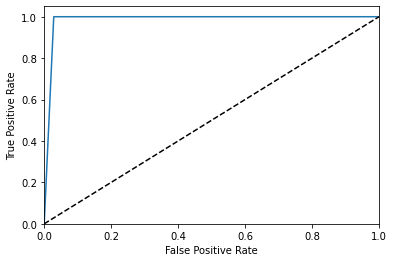

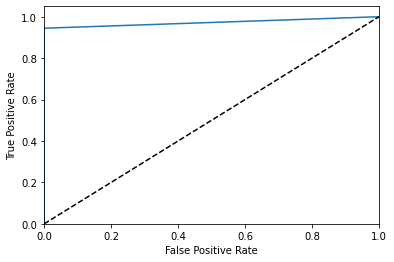

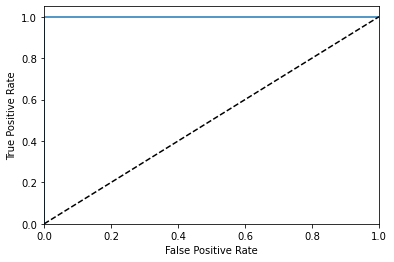

In [11]:
#ROC curve for multi-class classification
lb = LabelBinarizer()
lb_yTest = lb.fit(y_test).transform(y_test)
lb_prediction = lb.transform(prediction)

fpr = dict()
tpr = dict()
roc_auc = dict()
for targetclass in range(len(uniqueTarget)):
    fpr[targetclass], tpr[targetclass], _ = roc_curve(lb_yTest[:,targetclass], lb_prediction[:,targetclass])
    roc_auc[targetclass] = auc(fpr[targetclass], tpr[targetclass])
    print("Area Under the Curve:",roc_auc[targetclass])
for targetclass in range(len(uniqueTarget)):
    plt.figure()
    plt.plot(fpr[targetclass], tpr[targetclass], roc_auc[targetclass])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
plt.show()

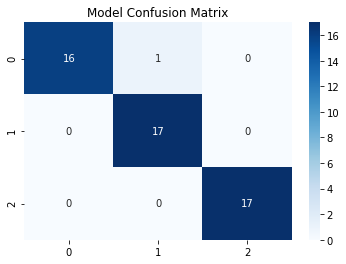

In [12]:
#Visualizing the heatmap for the model created
modelConfusionMatrix = confusion_matrix(prediction,y_test)
sns.heatmap(modelConfusionMatrix,annot=True,cmap='Blues')
plt.title('Model Confusion Matrix')
plt.show()

In [13]:
#Creating output CSV file as mentioned in the question
output = []
def outputCSVFile(prediction,y_test):
    result = pd.DataFrame()
    for i in range(len(y_test)):
        if prediction.values[i]==y_test[i]:
            output.append([prediction.values[i],y_test[i],'Match'])
            result = pd.DataFrame(output,columns=['Predicted Value','Original Value','Comparision'])
        else:
            output.append([prediction.values[i],y_test[i],'Unmatch'])
            result = pd.DataFrame(output,columns=['Predicted Value','Original Value','Comparision'])
    result.to_csv('Comparision.csv',index=False,sep='\t')

In [14]:
result = outputCSVFile(prediction,y_test)

In [15]:
#Logistics Regression using sklearn in-built library
lr = LogisticRegression()
scikitModel = lr.fit(X_train, y_train)

In [16]:
scikitModel.score(X_test, y_test)

0.9803921568627451

In [17]:
scikitModelPrediction = scikitModel.predict(X_test)
confusionMatrix = confusion_matrix(scikitModelPrediction, y_test)

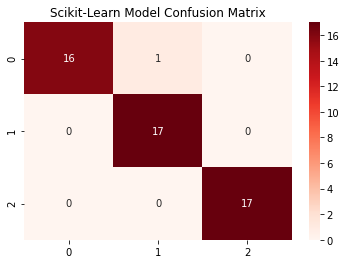

In [18]:
sns.heatmap(confusionMatrix,annot=True,cmap='Reds')
plt.title('Scikit-Learn Model Confusion Matrix')
plt.show()